In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [9]:
_parent_folder = "encoder_validation"
_folder_name = "sk28_et_0"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\encoder_validation'

In [57]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# set zero
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

_sk_df = set_zero(_sk_df, column_name = ["e_t", "e_rr", "e_rl"])
# rename columns
_sk_df["e_t"] =  -_sk_df["e_t"]

_sk_df

,sys_time,time,e_t,e_fl,e_rr,e_rl,rtc,mils,sync,ax,ay,az,gx,gy,gz,mx,my,mz
0,2023-03-10 18:10:02.698311,2023-03-10 18:10:02.698669,0,0,0,0,2023-03-10 11.40.01.000000 PM,1153034,0,-0.889648,0.197266,-0.107910,-0.183105,-0.061035,1.525879,783.969849,213.663010,-72.322121
1,2023-03-10 18:10:02.922034,2023-03-10 18:10:02.922161,0,0,0,0,2023-03-10 11.40.01.000000 PM,1153045,0,-0.890137,0.197266,-0.105957,-0.122070,-0.061035,1.525879,789.364136,204.760376,-87.819710
2,2023-03-10 18:10:02.922530,2023-03-10 18:10:02.922627,0,0,0,0,2023-03-10 11.40.01.000000 PM,1153056,0,-0.890625,0.196289,-0.105469,-0.061035,-0.122070,1.586914,787.566040,220.785110,-75.766022
3,2023-03-10 18:10:02.923026,2023-03-10 18:10:02.923140,0,0,0,0,2023-03-10 11.40.01.000000 PM,1153067,0,-0.888184,0.198730,-0.104980,-0.183105,-0.061035,1.586914,760.594604,201.199326,-80.931892
4,2023-03-10 18:10:02.923522,2023-03-10 18:10:02.923549,0,0,0,0,2023-03-10 11.40.01.000000 PM,1153078,0,-0.888184,0.196289,-0.108887,-0.183105,-0.122070,1.525879,785.767944,194.077225,-70.600166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955,2023-03-10 18:10:56.556070,2023-03-10 18:10:56.556546,98149,0,0,-1,2023-03-10 11.40.55.000000 PM,1206890,0,-0.888672,0.204102,-0.101562,-0.244141,-0.061035,1.525879,792.960327,197.638275,-70.600166
4956,2023-03-10 18:10:56.567161,2023-03-10 18:10:56.567520,98149,0,0,-1,2023-03-10 11.40.55.000000 PM,1206901,0,-0.888672,0.203613,-0.102051,-0.183105,-0.183105,1.586914,789.364136,201.199326,-63.712341
4957,2023-03-10 18:10:56.578076,2023-03-10 18:10:56.578307,98149,0,0,-1,2023-03-10 11.40.55.000000 PM,1206912,0,-0.891602,0.203125,-0.103516,-0.122070,0.000000,1.464844,778.575562,204.760376,-84.375801
4958,2023-03-10 18:10:56.588802,2023-03-10 18:10:56.589101,98149,0,0,-1,2023-03-10 11.40.55.000000 PM,1206923,0,-0.888184,0.203125,-0.105469,-0.122070,-0.244141,1.525879,774.979370,204.760376,-80.931892


In [11]:
# type in marker details
_xm = get_marker_name(1)
_zm = get_marker_name(3)
_om = get_marker_name(2)

In [12]:
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [13]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 4839/4839 [00:00<00:00, 124316.21it/s]


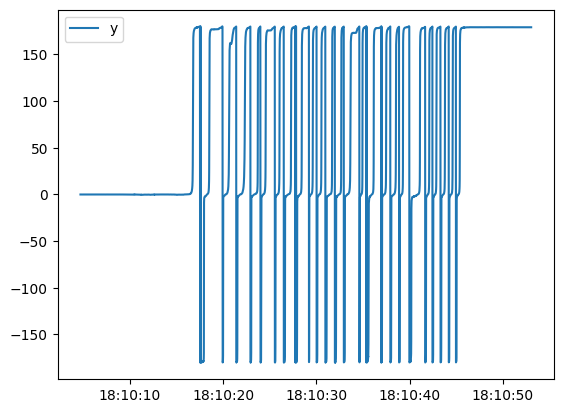

In [26]:
# plt.plot(_m_df["time"][1000:2000], _theta_x[1000:2000], label="x")
plt.plot(_m_df["time"], _theta_z, label="y")
# plt.plot(_m_df["time"][1000:2000], _theta_z[1000:2000], label="z")
plt.legend()


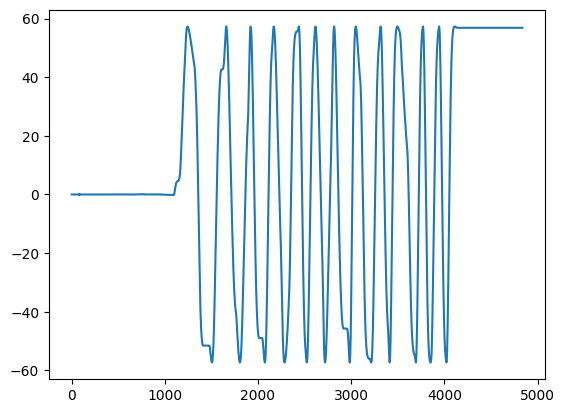

In [71]:
plt.plot(np.rad2deg(_mocap_df.rb_ang_y))

In [58]:
_ang_df = _sk_df[['time', 'e_t']].copy()

In [67]:
_ang_df["ang_y"] = _ang_df["e_t"].apply(lambda x: x*0.09)
# change angle to 0 to 360
_ang_df["ang_y"] = _ang_df["ang_y"].apply(lambda n: n%180)

# _ang_df["ang_y"] = _ang_df["ang_y"] - _ang_df["ang_y"][0]

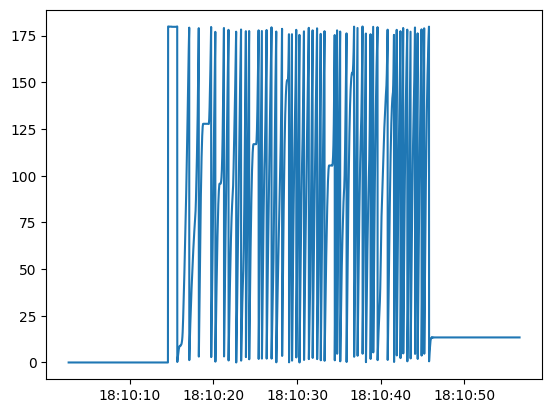

In [68]:
plt.plot(_ang_df["time"], _ang_df["ang_y"])